# "Hey, I know that name!"

For this project, my goal is to help users find names that "fit". If a name 1) feels familiar, and 2) tells you quickly that the named person is likely from a specific time period or age range, that's the kind of name that I'm looking for. Familiar, but unique enough to give you useful information about the person's age and the year. 

It's been talked about so often times that it's hard to find an original source, but the idea of "unique but familiar" is all over in marketing. Perhaps the most well-established version is "Most Advanced Yet Acceptable", coined by Raymond Loewy. Basically, people like things that are new, but fit somewhere they know. [(Atlantic article on Loewy)](https://www.theatlantic.com/magazine/archive/2017/01/what-makes-things-cool/508772/)

Say you want to market something to people around 65. Do you want to pick "Jacob" as a name in an ad? Probably not. The vast majority of people named "Jacob" are under 40. What if you wanted to have a believable name for someone 20-30 in a period piece set in 1990, or 1990-1995? Here, I use actuarial and birth name data to find the names that best fit that target window. Starting from how many years people born in a given year are likely to have lived, I calculate how many total years were lived by people with each name in a given age range, over a given year range. From there, I find which names had the biggest fraction of holders who qualify for that window. For example, looking at people 20-25 in 1990-1995, males named "Todd" were common. I then generate a composite score using both the fraction of holders and how common and how characteristic a given name is for that time period and age range window. 

In short: The user gives me a target year, a target endpoint, and a target age bracket, and I give them relatively common names that you're much more likely to find in that window than outside it.

The resulting interactive tool is the primary "deliverable" of this project. The current code currently generates a PNG and a `plotly` figure, which can both be easily embedded in html, but unfortunately, the database is too large for most low-cost hosting. It's clear why most baby-name explorers limit their analysis to the 1000 most-common names for each year!



*In the next component of the project, I explore the data further, clustering names by similarity and projecting future name trends based on existing data. See the "Names_modeling" document.*

### Terminology point:

This project relies on the way that names are categorized by the Social Security Administration. Each birth is registered as either male or female, and throughout the text, these terms refer to that assigned sex.

In [1]:
%config Completer.use_jedi = False
#Autocomplete has been finicky, switching versions. 

In [2]:
import numpy as np
import pandas as pd
import csv
import os
import time

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
import colorsys
from wordcloud import WordCloud

from plotly.subplots import make_subplots
import plotly.graph_objects as go

import datetime as dt
import pickle


In [3]:
#Set figure options:

matplotlib.rcParams['font.sans-serif'] = ['Helvetica']

plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=16)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
# plt.rc('legend', fontsize=12)    # legend fontsize
# plt.rc('figure', titlesize=10)  # fontsize of the figure title

In [4]:
#Load preprocessed data generated in "Names_calculate_reduced"
#or in prior actuarial estimates.

#From actuarial (small files):
alive_F = pd.read_pickle('./processed_variables/life_F_df2.pkl')
alive_M = pd.read_pickle('./processed_variables/life_M_df2.pkl')

#From 'Names_calculate_reduced':

#Total births, from SSA:
totalnames_table = pd.read_pickle('./processed_variables/Total_soc_cards.pkl')

# #Names dataframe, HANDLED BELOW
# names_df = pd.read_pickle('names_df.pkl')
# names_df_trim = pd.read_pickle('names_df.pkl')

#Year of birth data:
namelife_M_yob = np.load('./processed_variables/namelife_M_yob.npy')
namelife_F_yob = np.load('./processed_variables/namelife_F_yob.npy')
#"Base" life data (total of all ages alive each year):
namelife_M_base = np.load('./processed_variables/namelife_M_base.npy')
namelife_F_base = np.load('./processed_variables/namelife_F_base.npy')
#"Name" data: the names associated with each element:
namelife_M_name = np.load('./processed_variables/namelife_M_name.npy', allow_pickle=True)
namelife_F_name = np.load('./processed_variables/namelife_F_name.npy', allow_pickle=True)
#"Birth" data: the base how-many-per-year for all names:
namebirth_M = np.load('./processed_variables/namebirth_M.npy')
namebirth_F = np.load('./processed_variables/namebirth_F.npy')


#Calculated properties of the characteristic name sets:
sel_specif_F = np.load('./processed_variables/sel_specif_F140.npy')
sel_weight_F = np.load('./processed_variables/sel_weight_F140.npy')
sel_scores_F = np.load('./processed_variables/sel_scores_F140.npy')
sel_ages_F = np.load('./processed_variables/sel_ages_F140.npy')
sel_names_F = np.load('./processed_variables/sel_names_F140.npy', allow_pickle=True)
sel_inds_F = np.load('./processed_variables/sel_inds_F140.npy')

sel_specif_M = np.load('./processed_variables/sel_specif_M140.npy')
sel_weight_M = np.load('./processed_variables/sel_weight_M140.npy')
sel_scores_M = np.load('./processed_variables/sel_scores_M140.npy')
sel_ages_M = np.load('./processed_variables/sel_ages_M140.npy')
sel_names_M = np.load('./processed_variables/sel_names_M140.npy', allow_pickle=True)
sel_inds_M = np.load('./processed_variables/sel_inds_M140.npy')

In [5]:
#Load the year-of-birth data, in "yobYYYY.txt" format csv files,
#containing all names with over 5 births for the year "YYYY", 
#the four-digit year 
#
#Data source: https://www.ssa.gov/OACT/babynames/limits.html, I
#manually downloaded the national zip file that unpacks to a 
#folder containing the files below, renamed "names_YYYY", where
#"YYYY" is the four-digit year of the 

#REFRESH EVERY TIME. The "names_df" and "names_df_trim" data 
#structures take up just over 100MB, so they do not play nice 
#with Github. Takes maybe 10 seconds.

refresh = True

if refresh:

    #Drop down into the correct directory,
    os.chdir('../Names/names_2020')
    #grab a list of the files in it,
    current_dir = os.listdir()

    names_temp = []
    #step through them, loading and appending
    for ftemp in current_dir:
        if ftemp[-3:] == 'txt':
            dftemp = pd.read_csv(ftemp, names=['Name','Sex','Number'])
            dftemp['Year'] = int(ftemp[3:-4])
            names_temp.append(dftemp)

    #chop them all together
    names_df = pd.concat(names_temp)
    names_df.info()

    #go back up
    os.chdir('..')


    #Reset the indexes to unduplicate them, since each stack was indexed 
    #separately; keeping the old indices is handy though, so default
    #'drop = false' option is kept.

    #Yes, the sorting matters. It makes plotting way easier later on, and
    #I could definitely use it to speed up the name structure indexing. 

    names_df = names_df.reset_index().sort_values(['Name','Year'])



    #"names_df" is raw, not controlled for population or births. What was 
    #the total as a fraction of the year's name births? Currently only
    #using the total names included in this data as the core comparison.
    #Could pull from the social security total above in future changes.

    year_total = names_df.groupby('Year').sum()

    #Join year_total w/ names_df to get what fraction of named births
    #that year made up of the given name/sex pair:
    names_df = pd.merge(left=names_df, right=totalnames_table, 
                        left_on='Year', right_on='Year of birth', 
                        how='left')
    names_df['Fraction'] = names_df['Number']/names_df['Total']

    #Not normalizing to separate male or female births, only total.
    #Possibly another future improvement, since the likelihood of 
    #registering males/females appears to have been biased early on. 
    names_df.drop(columns=['Male','Female','Total'], inplace=True)

    #Calculate total number of births for each name:
    totalbirths_byname = names_df[['Name','Sex','Number']].groupby(['Name','Sex']).sum()

    trimvalue = 20
    #Limit dataset to names that had more than 20 total births
    #with that name:
    keepnames = totalbirths_byname[totalbirths_byname['Number'] > trimvalue]

    #Join on name/sex pairs to keep only ones included above
    names_df_trim = pd.merge(left=names_df, right=keepnames, on=['Name','Sex'], how='inner')
    #Handling number column ambiguity, not pretty but works fine
    names_df_trim['Number'] = names_df_trim['Number_x']
    names_df_trim.drop(columns=['Number_x', 'Number_y'], inplace=True)
    val1 = len(names_df.groupby(['Name','Sex']).size())
    val2 = len(names_df_trim.groupby(['Name','Sex']).size())
    val1a = len(names_df)
    val2a = len(names_df_trim)

    #Display results
    print('Pretrim -> posttrim, minimum {} births:\n'.format(trimvalue))
    print('Total names (total M/F separately):')
    print(val1, '->', val2)
    print('Total name/year records:')
    print(val1a, '->', val2a)
    print('\nRemoves {:.2f} of names while removing {:.3f} of total birth records.'.format((val1-val2)/val1, (val1a-val2a)/val1a))

    #names_df.to_pickle('names_df.pkl')
    #names_df_trim.to_pickle('names_df_trim.pkl')
    
else:
    names_df = pd.read_pickle('names_df.pkl')
    names_df_trim = pd.read_pickle('names_df.pkl')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2020863 entries, 0 to 32029
Data columns (total 4 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Name    object
 1   Sex     object
 2   Number  int64 
 3   Year    int64 
dtypes: int64(2), object(2)
memory usage: 77.1+ MB
Pretrim -> posttrim, minimum 20 births:

Total names (total M/F separately):
111472 -> 70589
Total name/year records:
2020863 -> 1956469

Removes 0.37 of names while removing 0.032 of total birth records.


In [6]:
#I'd love to get this working as an actual webpage, but the dataset
#is unfortunately too big. The variables are designed to work well
#as user inputs, however, as follows:


#"Target Year", input element, arbitrary integer 1882-2020
#(must allow 2 years after 1880, to fit minimum age range of +-2)
#VALUE: Target year (i.e. 1960)

#"Year Range", select element, options based on Target Year 
#(for 1882 or 2018, only +-0, more options when Age Range does not hit rails)
#VALUE: Year range, +-0, +-2, +-5 (i.e. 1960, 1958-1962, 1955-1965)

#"Target Age", input element, arbitrary integer 0-100
#(input values are limited by Target Year, replaced by max or min allowable if past rails)
#VALUE: Target age (i.e. 20)

#"Age Range", select element, options based on priors
#(input values are limited by Target Year and Target Age)
# -Age range, +-2 or +-5 (i.e. 18-22, 15-25)

#"Sex", select element, two options
# -Sex (i.e. M, F)


#Example of input hitting rails that automatically limit options:
#User inputs target year 2045.
#-> Year range options: +-0 or +-2 (2045 or 2043-2047)
#-> Age will be minimum of 25 (anyone under 25 is not born in present)
#-> Age range: +-2 (23-27)

#This ensures that any query entered can be answered.

# Begin visualization code

Below is the current visualization code. I am in the progress of optimizing this to work from a derived set of data, rather than calculating the full characteristic values for every name at every call. Currently, it uses a pair of matrices around (25000 | 40000) x 140 x 180 (~25k rows for male names, 40k rows for female names) which is a lot, but it could get by on the set of names/properties for each potential window and potential age. If I constrain the windows for year and age range to either 5 or 10 years and only save the top 100 names, then it's a (135+130) x (135+130) x 100 matrix for M and F each, cutting it down from >1 billion elements to ~15 million. 

From the user perspective, that would look like the user selecting a single year and a single age, then whether to use a window of 5 or 10 years around either.

In [7]:
#Goal colors: Plotly defaults, #EF553B (red), #636EFA (blue):
#https://www.rapidtables.com/convert/color/rgb-to-hsv.html
#HSV, red: 9deg, 75.3%, 93.7%
#HSV, blue: 236deg, 60.4%, 98.0%

In [8]:
#Convenience function to plot births for a given name

def showname(name, sex):
    subdf = names_df_trim[(names_df_trim['Name']==name) & (names_df_trim['Sex']==sex)]
    plt.figure(figsize=[14,4])
    plt.bar(subdf['Year'],subdf['Number'])
    plt.xlim([1880,2020])
    plt.title(f'Number of {name} ({sex}) born per year')
    plt.show()

In [9]:
#Primary data visualization function: WORD CLOUD

def display_namecloud(sizedict, coldict, sex, cmap):

    #DISPLAY:
    #TODO: Use viridis_r for individual-name age colormap

    #Make a circle mask
    cscale = 1000
    x, y = np.ogrid[:cscale, :cscale]
    mask = (x - cscale/2) ** 2 + (y - cscale/2) ** 2 > (cscale/2-20) ** 2
    mask = 255 * mask.astype(int)

    built_cloud = WordCloud(background_color='white',
                            repeat=False, 
                            width=800, 
                            height=500,
                            max_font_size=250,
                            min_font_size=24,
                            mask=mask)

    wcloud = built_cloud.generate_from_frequencies(sizedict)

    fig, ax = plt.subplots(1,1, figsize=[10,10])
    ax.axis('off')
    #plt.imshow(wcloud, interpolation='bilinear')
    #plt.show()

    #Alternative color pulled from:
    #https://amueller.github.io/word_cloud/auto_examples/a_new_hope.html
    #Also referenced from this:
    #https://stackoverflow.com/questions/47143461/python-wordcloud-color-by-term-frequency
    
    #Old version worked, but it was WAY overcomplicated. Existing
    #colormaps will look a lot better, and take much less work
    #than my finicky custom version of scaling each H/S/L element
    
    def color_func(coldictionary):
        max_col = 1.05*max(coldictionary.values())
        min_col = 0.95*min(coldictionary.values())
        def my_tf_color_func_inner(word, font_size, position, orientation, random_state=None,
                                   coldictionary=coldictionary, max_col=max_col, min_col=min_col, **kwargs):
            r, g, b, s = eval('cm.{}((coldictionary[word]-min_col)/(max_col-min_col))'.format(cmap))
            return "rgb({0}, {1}, {2})".format(int(r*255),int(g*255),int(b*255))
        return my_tf_color_func_inner

    plt.imshow(wcloud.recolor(color_func=color_func(coldict), random_state=3),
               interpolation="bilinear")
    plt.show()

In [10]:
#(Small number-to-string convenience functions for use in display_sparklines):
def round_sig(x, sig=2):
    return round(x, sig-int(np.floor(np.log10(abs(x))))-1)

def make_it_stringy(x):
    if x > 1000:
        return str(int(round(x/1000))) + 'k'
    if x < 1000:
        return str(int(round_sig(x, sig=2)))

In [30]:
#Primary data visualization function: SPARKLIKE TREND LINES

def display_sparklines(namerange_data,
                       year, yearrange, age, agerange, sex,
                       n_names=20):
    
    #ONLY UNPASSED CALL: namebirth_M/namebirth_F
    
    #Define convenience variables:
    coh1 = year - (age + agerange) #Oldest cohort: first year minus oldest
    coh2 = year + yearrange - (age) #Youngest cohort: last year minus youngest
    maxspecif = namerange_data[0].max() #Greatest name specificity, for scale
    maxweight = namerange_data[1].max() #Greatest number of births, for scale
    
    #Initialize figure with subplots
    fig = make_subplots(n_names+1, 1, 
                        shared_xaxes=True,
                        specs = [[{}] for n in range(n_names+1)],
                        vertical_spacing = 0,
                       )
    
    #Set variables appropriately based on name sex
    if sex=='M':
        birthsource = namebirth_M
        linecol = 'blue'
        fillbase = 'rgb({0},{0},255)'
    elif sex=='F':
        birthsource = namebirth_F
        linecol = 'red'
        fillbase = 'rgb(255,{0},{0})'
    
    #out_lines = np.zeros()
    for i in np.arange(n_names)+1:
        #Define single-name convenience variables 
        peakval = birthsource[namerange_data[5][-1*i],:].max()
        yearscale = 1*(yearrange + 1)
        anno_text = '<b>' + namerange_data[4][-1*i] + '</b> (age {0:.1f})<br>'.format(namerange_data[3][-1*i]) \
                    + '         Year fit score:   {0:.2f}<br>'.format(namerange_data[0][-1*i]/maxspecif) \
                    #+ '         Alive by year: {0:>5}'.format('~'+make_it_stringy(namerange_data[1][-1*i]/yearscale))
                    # #"Alive by year" currently does not control for the
                    # #method used to weight number of births, I will
                    # #need to correct that to re-enable it. 
        
        #Plotly plot generation
        #Add bounding box showing target birth years
        fig.add_trace(go.Scatter(x=[coh1, coh1, coh2, coh2],
                                 y=[0,1.2*peakval,1.2*peakval,0],
                                 fill="toself",
                                 mode='lines',
                                 line={'color':'lightgray'}
                                ), i+1, 1)
        #fig.add_trace(go.Scatter(x=[coh1, coh1, coh2, coh2],
        #                         y=[0,1.2*peakval,1.2*peakval,0],
        #                         fill="toself",
        #                         mode='lines',
        #                         line={'color':'gray'}
        #                        ), i+1, 1)
        #Add trace of name birth history
        fig.add_trace(go.Scatter(x=np.arange(1880,2050), 
                                 y=birthsource[namerange_data[5][-1*i],:],
                                 mode='lines', 
                                 line={'color':linecol,
                                       'width':max(5*peakval**0.75/100_000**0.75, 0.5)},
                                 name=namerange_data[4][-1*i],
                                 fill='tozeroy',
                                 fillcolor=fillbase.format(255 - 255*peakval**0.75/100_000**0.75),
                                ), i+1, 1)
        #Add text stating specificity/weight specifically
        fig.add_annotation(xref='x{}'.format(i+1), yref='y{}'.format(i+1),
                           x=coh2+45, y=0.55*peakval,
                           text=anno_text,
                           showarrow=False,
                           align='left',
                           width=200,
                           xshift=100)
        #Format subplot
        fig.update_xaxes(showgrid=False,
                         ticks='',
                         showticklabels=False,
                         range=[coh1-40, coh2+50],
                         domain=[0,.6],
                         zeroline=False,
                        )
        
    fig.update_yaxes(showgrid=False, ticks='', showticklabels=False)
    fig.add_annotation(xref='x1', yref='y1',
                       x=np.mean([coh1, coh2]), y=0.5*peakval,
                       text='<b>Names for {0} aged {1}-{2} in {3}-{4}:</b>'
                           .format(sex,
                                   age,
                                   age+agerange,
                                   year,
                                   year+yearrange,
                                  ),
                       showarrow=False,
                       align='left',
                       xshift=100)
    fig.update_layout(template=None, 
                      height=n_names*(100*0.55), 
                      width=500,
                      margin={'t':0,'b':0},
                      showlegend=False,
                     )

    fig.show()
    return 0

In [31]:
#Primary data visualization function: GENERATE VALUES AND CALL VIS FUNCTION(S)

def get_era_names(year, yearrange,
                  age, agerange,
                  sex,
                  n_names=25):
    """
    This function selects and rewraps data from the targeted year/age range
    to pass to the visualization functions. 
    
    'yearrange' options: [0, 4, 10] (year:year+1, year:year+5, year:year+11)
    'agerange' options: [4, 10] (age:age+5, age:age+11)
    
    These sets of options are symmetrical, can be centered around target
    rather than starting with target in future iterations. 
    
    Example input: 1990, 4, 20, 4
    Resulting tgt: years 1990-1994 (inclusive), ages 20-24 (inclusive)
    
    This target is then used to pull the matched preprocessed outputs from
    "sel_" datastructures, which are fed into the display function(s). 
    """
    
    
    inds = [year - 1880, 
            age, 
            [0,4,10].index(yearrange),
            [4,10].index(agerange)]

    if sex=="F":
        s_specif = sel_specif_F[inds[0],inds[1],inds[2],inds[3],:]
        s_weight = sel_weight_F[inds[0],inds[1],inds[2],inds[3],:]
        s_scores = sel_scores_F[inds[0],inds[1],inds[2],inds[3],:]
        s_ages = sel_ages_F[inds[0],inds[1],inds[2],inds[3],:]
        s_names = sel_names_F[inds[0],inds[1],inds[2],inds[3],:]
        s_inds = sel_inds_F[inds[0],inds[1],inds[2],inds[3],:]
    elif sex=="M":
        s_specif = sel_specif_M[inds[0],inds[1],inds[2],inds[3],:]
        s_weight = sel_weight_M[inds[0],inds[1],inds[2],inds[3],:]
        s_scores = sel_scores_M[inds[0],inds[1],inds[2],inds[3],:]
        s_ages = sel_ages_M[inds[0],inds[1],inds[2],inds[3],:]
        s_names = sel_names_M[inds[0],inds[1],inds[2],inds[3],:]
        s_inds = sel_inds_M[inds[0],inds[1],inds[2],inds[3],:]


    sizedict = {}
    coldict = {}
    for n in range(n_names):
        dictkey = s_names[-(n+1)]
        sizedict[dictkey] = int(np.sqrt(s_weight[-(n+1)]))
        coldict[dictkey] = np.sqrt(s_specif[-(n+1)])

    namerange_data = (s_specif, s_weight, s_scores, s_ages, s_names, s_inds)
    
    #REFERENCE SCORE GENERATION EQUATION (from "Names_calculate_reduced")
    #    name_score = 10 * (np.log10(name_weight+1))**2 * name_specificity
    
    #CORE DISPLAY FUNCTION CALL: NAMECLOUD
    if sex=='M':
        display_namecloud(sizedict, coldict, sex, 'Blues')
    else:
        display_namecloud(sizedict, coldict, sex, 'Reds')
    
    #CORE DISPLAY FUNCTION CALL: SPARKLINES
    display_sparklines(namerange_data, 
                       year, yearrange, age, agerange, sex,
                       n_names=30)
    
    return namerange_data

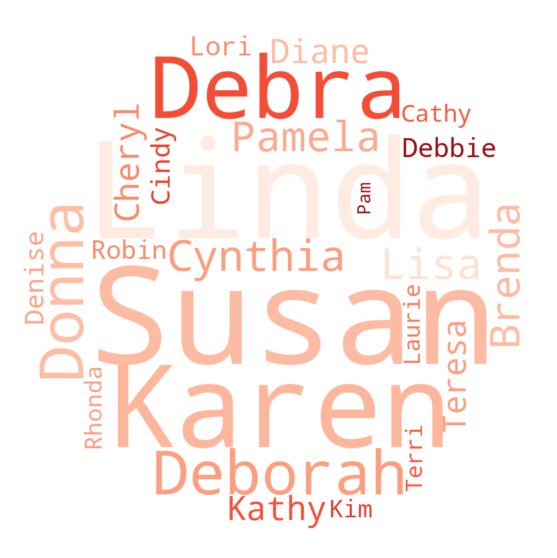

In [32]:
target_range2 = [1990, 4, 30, 4, 'F']

namerange_data = get_era_names(*target_range2)






# Characteristic names: Yes 

Based on a given era and a given age range, can we find names that feel right? Looks like yes!

Both visualizations are deployable. The first is a png, and Plotly is simple to get html from.

In [ ]:
#OPTIONAL VISUALIZATION: Specificity vs. number alive. Good for
#eyeballing how the score algorithm balances between the two!

#Needs to include cutoff score!
ann_num = 10
plt.figure(figsize=[10,6])
plt.scatter(namerange_data[0], namerange_data[1], c=namerange_data[2])
for n in range(-1*ann_num,0):
    plt.annotate(text=namerange_data[4][n], 
                 xy=(namerange_data[0][n], namerange_data[1][n]),
                 xytext=(2,2),
                 textcoords='offset points',
                 rotation=30
                )
plt.xlabel("Specificity: Fraction of name's years that were lived in range")
plt.ylabel('Weight: Number of name-years lived')
# plt.ylim([-200000, 1.15*max(namerange_data[1])])
plt.box()
cbar = plt.colorbar()
cbar.ax.set_ylabel('Characteristicness Score')
plt.title('Years: {}, Ages: {}, Sex: {}'.format([target_range2[0], target_range2[0]+target_range2[1]],
                                                [target_range2[2], target_range2[2]+target_range2[3]],
                                                target_range2[4]))
plt.yscale('log')
plt.xscale('log')
plt.show()

As you can see, the algorithm is doing a good job catching "outliers" in weight/specificity relationship. NOTE: Be aware that the apparent baseline trend in this graph is artificial! We are only keeping the top 140 names in score. Any name below a certain score threshold is not included. There are still names in that area, but they do not fit well. 

In [ ]:
#Generate cluster timecourses:

cluster_courses = np.zeros([len(np.unique(tgt_affprop.labels_)),nametest_M_birth.shape[1]])
for i,cluster_id in enumerate(np.unique(tgt_affprop.labels_)):
    cc = nametest_M_birth[tgt_affprop.labels_==cluster_id,:]
    cluster_courses[i,:] = np.sum(cc, axis=0)
    
#Normalize to year total -> fraction of year's births in X cluster
cc_norm = cluster_courses/np.sum(cluster_courses, axis=0)
#Normalize from fraction of year to standard scale
cc_norm2 = (cc_norm - np.mean(cc_norm, axis=1).reshape(-1,1))/np.std(cc_norm, axis=1).reshape(-1,1)

# plt.plot(cc_norm.T)
# plt.show()

In [ ]:
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import train_test_split

#Fit first-10 with visual verification:
name_linmodels = []

#The scores are often terrible, because it's comparing versus
#using the mean of the KNOWN data, but visually inspecting the
#first 30 or so it's actually doing a reasonable job in most
#cases. 
for n in range(30):
    lin_mod = Ridge(alpha=0.01)

    y_examp = nametest_M_birth[n,:].T
    X_examp = np.hstack([cc_norm2.T, np.arange(1880,2020).reshape(-1,1)])

    #Random split:
    #X_train, X_test, y_train, y_test = train_test_split(X_examp, y_examp, test_size=0.25)
    #Year split:
    X_train, X_test, y_train, y_test = X_examp[:-5], X_examp[-5:], y_examp[:-5], y_examp[-5:]

    lin_mod.fit(X_train, y_train)
    
    y_pred = lin_mod.predict(X_test)
    
    print(nametest_M_name.iloc[n])
    print(lin_mod.score(X_test, y_test))
    
    plt.plot(X_train[:,-1], y_train, 'b.')
    plt.plot(X_test[:,-1], y_test, 'b+')
    plt.plot(X_test[:,-1], y_pred, 'rx')
    plt.legend(['Train','Test-actual','Test-pred'])
    plt.show()
    

In [ ]:
%%time

X_examp = np.hstack([cc_norm2.T, np.arange(1880,2020).reshape(-1,1)])

#Re-fit using entire set prior to the last 5 years. Repeat this multiple
#times using random sets of the data each time. 

n_refits = 20
name_linmodels = []
# name_linmodels = np.zeros([nametest_M_birth.shape[0], X_examp.shape[1], n_refits])
name_linmodels_dic = {}
test_scores = []

for n in range(len(nametest_M_name)):
    y_examp = nametest_M_birth[n,:].T

    lin_mod = RidgeCV(cv=n_refits, alphas=[.1])

    #Primitive bootstrap: Fit on partial data repeatedly, then average. 
    #Year split:
    X_train, X_test, y_train, y_test = train_test_split(X_examp[:-5], y_examp[:-5], test_size=0.1)
    lin_mod.fit(X_train, y_train)

    name_linmodels.append(lin_mod)
    #name_linmodels[m, :, n] = lin_mod.coef_

    test_score = lin_mod.score(X_examp[-5:], y_examp[-5:])
    test_scores.append(test_score)
    print('{0}: train {1:.3f}, test {2:.3f}, val {3:.3f} ({4})'.format(nametest_M_name.iloc[n],
                                                                       lin_mod.score(X_train, y_train),
                                                                       lin_mod.score(X_test, y_test),
                                                                       test_score,
                                                                       n
                                                                      ))
    y_pred_st = lin_mod.predict(X_test)
    y_pred_fu = lin_mod.predict(X_examp[-5:])
    if n%20==0:
        plt.plot(X_train[:,-1], y_train, 'b.')
        plt.plot(X_test[:,-1], y_test, 'b+')
        plt.plot(X_test[:,-1], y_pred_st, 'rx')
        plt.plot(X_examp[-5:,-1], y_examp[-5:], 'c+')
        plt.plot(X_examp[-5:,-1], y_pred_fu[-5:], 'mx')
        plt.legend(['Train','Test-actual','Test-pred','Val.-actual','Val.-pred'])
        plt.show()
    name_linmodels_dic[nametest_M_name.iloc[n]] = lin_mod

As you can see in the interspersed test plots, while the scores are very poor, that's because the scoring compares them against the *known* mean value of the last five years. They're actually reasonable predictions given the past history of the name in most cases! Even hitting a score of zero (performing as well as the actual mean of the last five years) is quite good. There are a few notable problems, though. For example, the estimates are often overly-optimistic for names that are currently in a long-term low. It really thought Bert and Cletus were going to come back, for example. Similarly, it sometimes heads significantly negative, which is an obvious problem. 

In [ ]:
len(name_linmodels)

## Name trend detection preliminary conclusion:

With careful variable preprocessing, a simple linear model does a surprisingly good job of tracking name trends without drastic overfitting. I'd need to extend this significantly to allow next-year prediction (i.e. generating projected name-cluster data), but it's a clear sign that we can reasonably track some trends for relatively popular names. To use the prior model for predictions, we'd have to generate synthetic cluster-trend data, which is feasible. For example, let's plug what we have into a time-series model like ARIMA, which uses the time course of the data to project its future trajectory. This is like to do reasonably well for near-future projection, and we can use that projection to generate the synthetic cluster trends necessary for the linear model to predict. Of course, we could also use the ARIMA directly on each name, but that would take hours for the full set of names compared to seconds for the linear model, and would also discard the information we can calculate about how names trend together. 

(Aside: This might actually be a pretty good spot for a multidimensional Kalman filter, which would use information from each timecourse variable quite nicely. I've been waiting for an excuse to get one of those going, might finally be the time!)  
(Also, there are 0 babies named Arima in the names database, which is honestly a little surprising.)

## ARIMA name timecourse projection:


In [ ]:
len(names_df_trim[names_df_trim['Name'] == 'Arima'])

In [ ]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split

#Handy reference for transforms:
#https://alkaline-ml.com/pmdarima/usecases/sun-spots.html

In [ ]:
%%time

#Testing this on most recent 5 years, so all but last 5 in training set
tsize = 135

num_clust = cc_norm2.shape[0]

arima_mods = []
for n in range(num_clust):
    y = cc_norm2[n,:]
    y_train, y_test = train_test_split(y, train_size=tsize)

    arima_mod = pm.auto_arima(y_train)

    y_pred = arima_mod.predict(y_test.shape[0])  # predict N steps into the future

    ## Visualize the forecasts (blue=train, green=forecasts)
    #x = np.arange(y.shape[0])
    #plt.plot(x[:tsize], y_train, c='blue')
    #plt.plot(x[tsize:], y[tsize:], 'b--')
    #plt.plot(x[tsize:], y_pred, c='green')
    #plt.show()
    
    arima_mods.append(arima_mod)

In [ ]:
#Build the predicted-cluster-trend matrix

y_pred_arima = np.zeros([num_clust, 5])
for n in range(num_clust):
    y_pred_arima[n,:] = arima_mods[n].predict(5)

### Actual name trend predictions:

In [ ]:
%%time

#STEP 1: REDO THE ARIMAS WITH ALL YEARS

tsize = 140

num_clust = cc_norm2.shape[0]

arima_mods = []
for n in range(num_clust):
    y = cc_norm2[n,:]
    #y_train, y_test = train_test_split(y, train_size=tsize)
    y_train = y

    arima_mod = pm.auto_arima(y_train)

    y_pred = arima_mod.predict(5)  # predict N steps into the future

    ## Visualize the forecasts (blue=train, green=forecasts)
    #x = np.arange(y.shape[0])
    #plt.plot(x[:tsize], y_train, c='blue')
    #plt.plot(x[tsize:], y[tsize:], 'b--')
    #plt.plot(x[tsize:], y_pred, c='green')
    #plt.show()
    
    arima_mods.append(arima_mod)

In [ ]:
y_pred_arima.shape

In [ ]:
#Build the predicted-cluster-trend matrix

y_pred_arima = np.zeros([num_clust, 5])
for n in range(num_clust):
    y_pred_arima[n,:] = arima_mods[n].predict(5)

#Add the pre-predicted value to the stack to convert the 5
#predicted values to a change (6 vals -> 5 differences)
baseval = cc_norm2[:,-1]
y_pred_arima = np.hstack([baseval.reshape(-1,1),y_pred_arima])
#Calculate the X-predicted in the difference format:
X_pred_arima = np.hstack([np.diff(y_pred_arima).T, np.arange(2020,2025).reshape(-1,1)])

In [ ]:
X_pred_arima.shape

In [ ]:
X_examp.shape

In [ ]:
%%time

#STEP 2: Redo the linear fits to include the complete dataset.

#1. Convert to CHANGE by year (solves most of the negatives problems)
temp_delta = np.diff(cc_norm2) #yes, correct axis (1) is default
temp_bdelta = np.diff(nametest_M_birth) #^same

#2. Start in 1881, since that's the first year we can do diff for
X_examp = np.hstack([temp_delta.T, np.arange(1881,2020).reshape(-1,1)])

n_refits = 20
name_linmodels = []
name_linmodels_dic = {}
test_scores = []

for n in range(len(nametest_M_name)):
    y_examp = temp_bdelta[n,:].T
    
    lin_mod = RidgeCV(cv=n_refits, alphas=[.1])
    
    #With this few data points, I'm throwing the whole thing in for now.
    #The CV is using a subset each time already.
    
    #X_train, X_test, y_train, y_test = train_test_split(X_examp, y_examp, test_size=0.1)
    X_train, y_train = X_examp, y_examp
    lin_mod.fit(X_train, y_train)

    name_linmodels.append(lin_mod)
    
    print('{0}: train {1:.3f} ({2})'.format(nametest_M_name.iloc[n],lin_mod.score(X_train, y_train), n))
    y_pred_fu = lin_mod.predict(X_pred_arima)
    if n%20==0:
        plt.plot(X_train[:,-1], y_train, 'b.')
        #plt.plot(X_test[:,-1], y_test, 'b+')
        #plt.plot(X_test[:,-1], y_pred_st, 'rx')
        #plt.plot(X_examp[-5:,-1], y_examp[-5:], 'c+')
        #plt.plot(X_examp[-5:,-1], y_pred_fu[-5:], 'mx')
        plt.plot(np.arange(2020,2025), y_pred_fu)
        plt.legend(['Train','Test-actual','Test-pred','Val.-actual','Val.-pred'])
        plt.show()
    name_linmodels_dic[nametest_M_name.iloc[n]] = lin_mod

In [ ]:
#STEP 3: MAKE NAME PROJECTIONS

n_names = len(nametest_M_name)

name_futures = np.zeros([n_names,5])
for n in range(n_names):
    name_futures[n,:] = name_linmodels[n].predict(X_pred_arima)
    

In [ ]:
#Testrun: First 30 names

for n in range(30):
    plt.plot(np.arange(1880,2020), nametest_M_birth[n,:])
    plt.plot(np.arange(2020,2025), nametest_M_birth[n,-1] + name_futures[n,:] - name_futures[n,0], 'b+')
    plt.title(nametest_M_name.iloc[n])
    plt.show()

Modifications: I should do a log transform on the data early on, to convert it closer to a normal-distribution range of values, which would respond more appropriately to linear fitting. That's going near the top of the list, it will have a real effect on how well most models can characterize the data. 

Overly-optimistic predictions for near-dead names could be handled better at the individual-name level with ARIMA, despite the drastically slower processing. Similarly, ARIMA would likely also do fairly well avoiding negatives, since the graph tends to flatten as it nears zero. That's largely handled with the transition to yearly change, though. A hybrid model using both could probably do pretty well, but it would be difficult to reasonably fit given the data, and at that point you might want to head into more complex territory like RNN. 

Anyway, predicting names is inherently a difficult problem. We don't have reliable time components to the signal that we can account for, or a massive pile of datapoints. There are generation-related timing elements, but those are close to random, and how long trends persist may be changing. 

Pulling in data on name popularity on a state-by-state basis would help quite a bit, bumping our dataset from about 140 datapoints to about 5000 (some state reporting didn't get going until later if I'm recalling right, so it's not quite 140 x 51). It certainly wouldn't solve the problem by itself! State name trends are strongly correlated with national trends, especially as media increasingly moves away from the local level. State data could significantly help, but it will be necessary to use models that account for correlation between variables. 

Future directions for name trend prediction, in summary:
- More in-depth data transformation prior to analysis/modeling (log or Box-Cox transform built into `pmdarima`, for example)
- Consider multivariate autoregression (i.e. VAR) to model multivariate time series data more effectively (not likely to make the ARIMA fitting feasible for individual names without a days-long run)  
- Consider reweighting recent years. Names with a strong recent increase are at a disadvantage in threshold, despite strong likelihood of continuing future presence. Could weigh name prevalence more highly in the last 3-5 years, for example, both to avoid cutting them off at the threshold stage and to increase the attention the model pays to recent trends? Something to consider.
- Add state data to improve models (at minimum should reduce year-level noise, important now that it's predicting based on yearly change)
- Toss this into an actual user interface/prediction engine. 

In [ ]:
#Assorted fun side comparisons:

#Names in '50 ways to leave your lover' by Paul Simon:
#https://www.azlyrics.com/lyrics/paulsimon/50waystoleaveyourlover.html
#Jack, Stan, Roy, Gus, Lee

#Names in 'Mambo No. 5' by Lou Bega:
#https://www.azlyrics.com/lyrics/loubega/mambono5.html
#Angela, Pamela, Sandra, Rita, Monica, Erica, Rita (again), Tina, Sandra, Mary, Jessica

#Names in '88 lines about 44 wome' by The Nails:
#https://genius.com/The-nails-88-lines-about-44-women-lyrics
#Deborah, Carla, Mary, Susan, Reno, Cathy, Vicki, Kamela, Xylla, Joan, Sherry, Kathleen,
#Seattle, Karen, Jeannie, Mary Ellen, Gloria, Mimi, Marilyn, Julie, Rhonda, Patty, Linda, 
#Katherine, Pauline, Jean-Marie, Gina, Jackie, Sarah, Janet, Tanya, Brenda, Rowena, Dee Dee, 
#Debbie Ray, Nina, Bobbi, Eloise, Terri, Ronnie, Jezebel, Dinah, Judy, Amaranta

#State names:
#(self-evident)

#City names: 
#US cities by population (>100,000):
#https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population

#Worldwide cities (>5,000,000):
#https://en.wikipedia.org/wiki/List_of_largest_cities

#Urban vs. rural states:
#https://fivethirtyeight.com/features/how-urban-or-rural-is-your-state-and-what-does-that-mean-for-the-2020-election/
#(Loosely, how many people are within 5 miles of a given census tract)

#Check trendiness: It looks in general like the time course for F
#names may be shorter than the time course for M names. Is that
#true, and if so has it been becoming less true since 2000?

#Could look at that by taking 10-year chunks (looks like about the
#right length to capture a rising or falling trend) and seeing which
#names correlate together for each chunk? Automatic grouping based
#on "trendiness" would be pretty cool. 

#Extend data: I could also cross-correlate names with Google ngrams 
#results for that name, that would be a nice comparison. Excellent
#proxy for whether a name is culturally established!

#Extend data: Cross-correlate artists who made the Billboard top 10
#using their names (i.e. Alanis). Only include cases where the name
#is in both, so simple inner join would be ideal. 


In [ ]:
showname('Xzavier')